In [26]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import joblib
from ds_creation.ds_utility import get_file_count, get_other_class
from prototypical.model.loader import load_and_preprocess_image, embedding
from CNN.loader import get_test, get_split
from ds_creation.plot_utility import confusion_matrix_plot, metrics_plot_builder, get_metrics
from tqdm import tqdm
import contextlib
import io
from prototypical.model.prototypical import calc_euclidian_dists
from sklearn.metrics import classification_report, accuracy_score


MODELS_METRICS_DIR = os.path.join("models_metrics", '02-11_training')
CNN_MODEL_DIR = os.path.join(MODELS_METRICS_DIR, "51_final_model.keras")
FULL_CNN_MODEL_DIR = os.path.join(MODELS_METRICS_DIR, "51_final_model.keras")
PROTO_MODEL_DIR = os.path.join('data_cache', 'proto', 'test_mammals_calls.keras')
SPLIT_DIR = os.path.join("data", "mammals_calls", "splits", "custom")
DATA_DIR = os.path.join("data", "mammals_calls_test")
CNN_PREDICT = False
PROTO_PREDICT = False
FULL_CNN_PREDICT = False
FOREST_PREDICT = True

species = get_file_count(DATA_DIR)


In [27]:
# in other_species_list devono finire tutte le classi utilizzate solo dalla prototypical
# queste classi sono contenute nei file di testo che indicano lo split da utilizzare per 
# il train/test della prototypical. Il complementare di queste classi deve essere classificato dalla CNN

other_species_list = []
for file in os.listdir(SPLIT_DIR):
    if file.endswith(".txt"):
        with open(os.path.join(SPLIT_DIR, file), 'r') as f:
            lines = f.readlines()
            other_species_list.extend([line.strip() for line in lines])

# creation of the other directory
other_dict = get_other_class(DATA_DIR, other_species_list)

# dataframe with filenames, labels and an other boolean flag for the other class
other_df = pd.DataFrame((other_dict.items()), columns=['label', 'filenames'])
other_df = other_df.explode('filenames').reset_index(drop=True)
other_df['filenames'] = other_df.apply(lambda x: os.path.join(DATA_DIR, x['label'], x['filenames']), axis=1)
other_df['other'] = 1
print(other_df.head())

                 label                                          filenames  \
0  West_Indian_Manatee  data/mammals_calls_test/West_Indian_Manatee/64...   
1  West_Indian_Manatee  data/mammals_calls_test/West_Indian_Manatee/64...   
2  West_Indian_Manatee  data/mammals_calls_test/West_Indian_Manatee/64...   
3  West_Indian_Manatee  data/mammals_calls_test/West_Indian_Manatee/64...   
4  West_Indian_Manatee  data/mammals_calls_test/West_Indian_Manatee/64...   

   other  
0      1  
1      1  
2      1  
3      1  
4      1  


In [28]:
# list of all species excluding 'other' and those in other_species_list
species = os.listdir(DATA_DIR)
species = [spec for spec in species if spec != 'other' and spec not in other_species_list]
print(len(species), "species found.")
print(len(other_species_list), "'other' species used.")

# dataframe with filenames, labels and an other boolean flag for the non-other classes
species_dict = {}
for spec in species:
    spec_path = os.path.join(DATA_DIR, spec)
    files = os.listdir(spec_path)

    files = [os.path.join(spec_path, f) for f in files]
    species_dict[spec] = files

test_df = pd.DataFrame((species_dict.items()), columns=['label', 'filenames'])
test_df = test_df.explode('filenames').reset_index(drop=True)
test_df['other'] = int(0)

# concatenate the two dataframes
test_df = pd.concat([test_df, other_df], ignore_index=True)
print("Total test samples:", len(test_df))
print(test_df.head())

12 species found.
39 'other' species used.
Total test samples: 17572
          label                                          filenames  other
0  Bearded_Seal  data/mammals_calls_test/Bearded_Seal/72021001-...      0
1  Bearded_Seal  data/mammals_calls_test/Bearded_Seal/72021009-...      0
2  Bearded_Seal  data/mammals_calls_test/Bearded_Seal/7202100A-...      0
3  Bearded_Seal  data/mammals_calls_test/Bearded_Seal/78018002-...      0
4  Bearded_Seal  data/mammals_calls_test/Bearded_Seal/66037003-...      0


In [29]:
w = 397
h = 164
c = 3

tqdm.pandas()

def CNN_test(test_sample, model, mapping):
    image = load_and_preprocess_image(test_sample["filenames"], {'h': h, 'w': w})
    image = tf.expand_dims(image, 0)
    with contextlib.redirect_stdout(io.StringIO()):
        predictions = model.predict(image)
    predicted_index = np.argmax(predictions, axis=1)
    predicted_label = mapping[predicted_index[0]]
    test_sample['CNN_predicted_label'] = predicted_label
    test_sample['CNN_predicted_index'] = int(predicted_index)
    return test_sample

def proto_test(test_sample, emb_ref, mapping):
    image = load_and_preprocess_image(test_sample["filenames"], {'h': h, 'w': w})
    image_list = [image]
    sample_embedding = embedding(image_list, {'w':w, 'h':h, 'c':3}, os.path.join('data_cache', 'proto', 'test_mammals_calls.keras'))

    emb_ref['distance'] = emb_ref['embeddings'].apply(lambda x: tf.reduce_mean(tf.math.pow(sample_embedding - x, 2)))

    class_pred = emb_ref[emb_ref['distance'] == emb_ref['distance'].min()]
    test_sample['proto_predicted_label'] = class_pred['class'].values[0]

    return test_sample


def label_to_index(labels, mapping):
    for key, val in mapping.items():
        if val == labels:
            return key
        if val == 'other':
            other = key
    return other

# Load CNN model and embeddings
cnn_model = tf.keras.models.load_model(CNN_MODEL_DIR)
emb_ref = pd.read_pickle("proto_embeddings.pkl")

# Load mapping from index to label
cnn_mapping = pd.read_csv(os.path.join(MODELS_METRICS_DIR, "label_to_index.csv"))
cnn_mapping = cnn_mapping.set_index('index')['label'].to_dict()

# Add index_label column to test_df
test_df['index_label'] = test_df.apply(lambda x: label_to_index(x['label'], cnn_mapping), axis=1)
test_df['index_label'] = test_df['index_label'].astype(int)

# Add columns for predictions
test_df['CNN_predicted_label'] = ''
test_df['CNN_predicted_index'] = -1

# Get CNN predictions
if FULL_CNN_PREDICT:
    full_cnn_model = tf.keras.models.load_model(FULL_CNN_MODEL_DIR)
    cnn_pred_df = test_df.progress_apply(lambda x: CNN_test(x, full_cnn_model, cnn_mapping), axis=1)
    cnn_pred_df.to_csv("cnn_full_predictions.csv", index=False)
else:
    cnn_pred_df = pd.read_csv("cnn_full_predictions.csv")

if CNN_PREDICT:
    cnn_pred_df = test_df.progress_apply(lambda x: CNN_test(x, cnn_model, cnn_mapping), axis=1)
    cnn_pred_df.to_csv("cnn_predictions.csv", index=False)
else:
    cnn_pred_df = pd.read_csv("cnn_predictions.csv")

# Get Prototypical predictions for samples predicted as 'other' by CNN
if PROTO_PREDICT:
    proto_test_df = cnn_pred_df[cnn_pred_df['CNN_predicted_label'] == 'other'].reset_index(drop=True)
    proto_test_df['proto_predicted_label'] = ''
    proto_pred_df = proto_test_df.progress_apply(lambda x: proto_test(x, emb_ref, cnn_mapping), axis=1)
    proto_pred_df.to_csv("proto_predictions.csv", index=False)
else:
    proto_pred_df = pd.read_csv("proto_predictions.csv")

if FOREST_PREDICT:
    random_forest_model = joblib.load(os.path.join('models_metrics', 'random_forest_mfcc_model.joblib'))
    # prendo il csv con gli mfcc e aggiungo una colonna con il nome del file
    # TODO: calcolare mfcc di tutti gli audio
    mfcc_df = pd.read_pickle('audio_data.pkl')
    mfcc_df['file_name'] = mfcc_df['audio_files'].apply(lambda x: os.path.basename(x))
    mfcc_df = mfcc_df.drop(columns=['idx_gruppo'])
    mfcc_df['species'] = mfcc_df['species'].apply(lambda x: x.replace(',', ''))

    label_to_index_mapping_forest = pd.read_csv(os.path.join('models_metrics', 'label_to_index_forest.csv'))
    print(cnn_pred_df.info())
    cnn_pred_df = cnn_pred_df[cnn_pred_df['CNN_predicted_label'] == 'other']
    print(len(cnn_pred_df), "samples predicted as 'other' by CNN for Random Forest classification.")
    cnn_pred_df['file_name'] = cnn_pred_df['filenames'].apply(lambda x: os.path.basename(x))
    cnn_pred_df = cnn_pred_df.rename(columns={'label': 'species'})

    # creo i dataframe finali di train e test unendo i due dataframe precedenti con il dataframe degli mfcc
    random_forest_test_df = pd.merge(cnn_pred_df, mfcc_df, on=['species', 'file_name'], how='left').dropna().reset_index(drop=True)
    print("Final test samples for Random Forest:", len(random_forest_test_df))

    y_test = random_forest_test_df['species']
    y_test = y_test.map(lambda x: label_to_index_mapping_forest[label_to_index_mapping_forest['label'] == x]['index'].values[0])
    x_test = pd.DataFrame(random_forest_test_df['chunk_list'].tolist())
    x_test.columns = [f'mfcc_feature_{i}' for i in range(x_test.shape[1])]
    print(y_test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17572 entries, 0 to 17571
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   label                17572 non-null  object
 1   filenames            17572 non-null  object
 2   other                17572 non-null  int64 
 3   index_label          17572 non-null  int64 
 4   CNN_predicted_label  17572 non-null  object
 5   CNN_predicted_index  17572 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 823.8+ KB
None
1450 samples predicted as 'other' by CNN for Random Forest classification.
Final test samples for Random Forest: 1374
0        7
1        7
2        7
3        7
4        7
        ..
1369    17
1370    17
1371    17
1372    17
1373    17
Name: species, Length: 1374, dtype: int64


## Grafici CNN

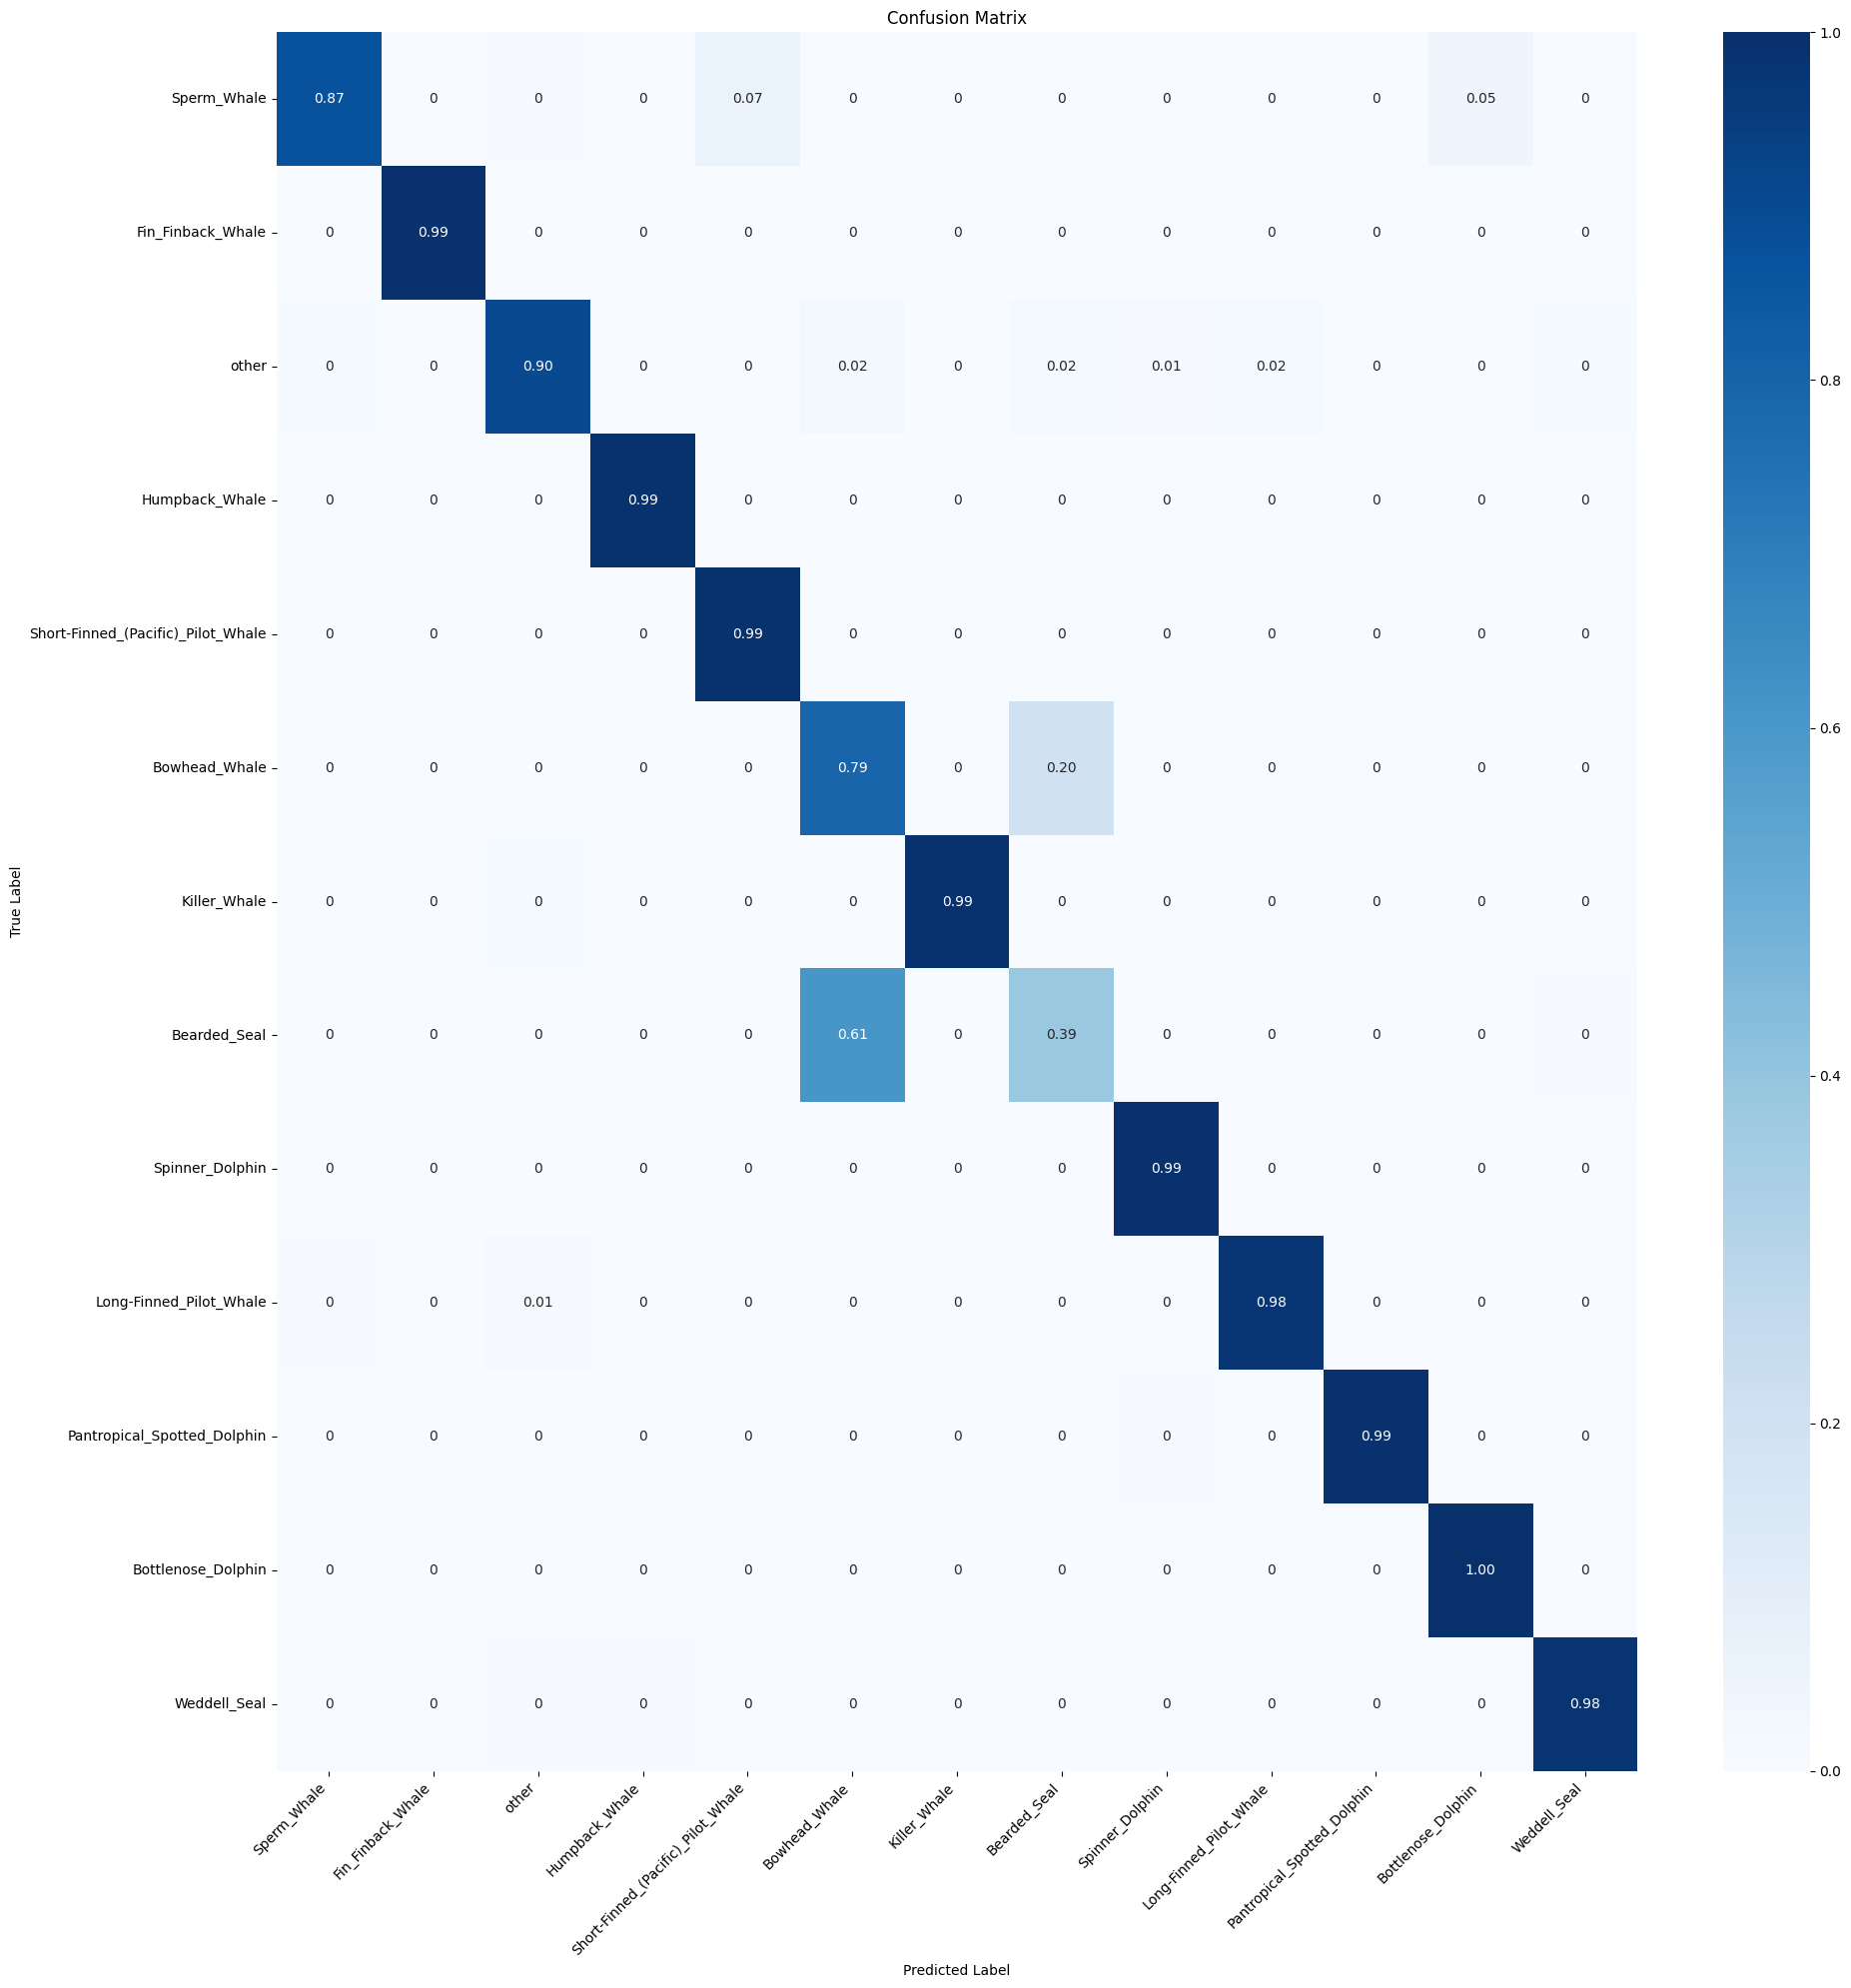

{0: {'label': 'Sperm_Whale', 'index': 0, 'support': 8527}, 1: {'label': 'Fin_Finback_Whale', 'index': 1, 'support': 2655}, 2: {'label': 'other', 'index': 2, 'support': 1519}, 3: {'label': 'Humpback_Whale', 'index': 3, 'support': 1256}, 4: {'label': 'Short-Finned_(Pacific)_Pilot_Whale', 'index': 4, 'support': 533}, 5: {'label': 'Bowhead_Whale', 'index': 5, 'support': 511}, 6: {'label': 'Killer_Whale', 'index': 6, 'support': 478}, 7: {'label': 'Bearded_Seal', 'index': 7, 'support': 474}, 8: {'label': 'Spinner_Dolphin', 'index': 8, 'support': 352}, 9: {'label': 'Long-Finned_Pilot_Whale', 'index': 9, 'support': 337}, 10: {'label': 'Pantropical_Spotted_Dolphin', 'index': 10, 'support': 336}, 11: {'label': 'Bottlenose_Dolphin', 'index': 11, 'support': 323}, 12: {'label': 'Weddell_Seal', 'index': 12, 'support': 271}}


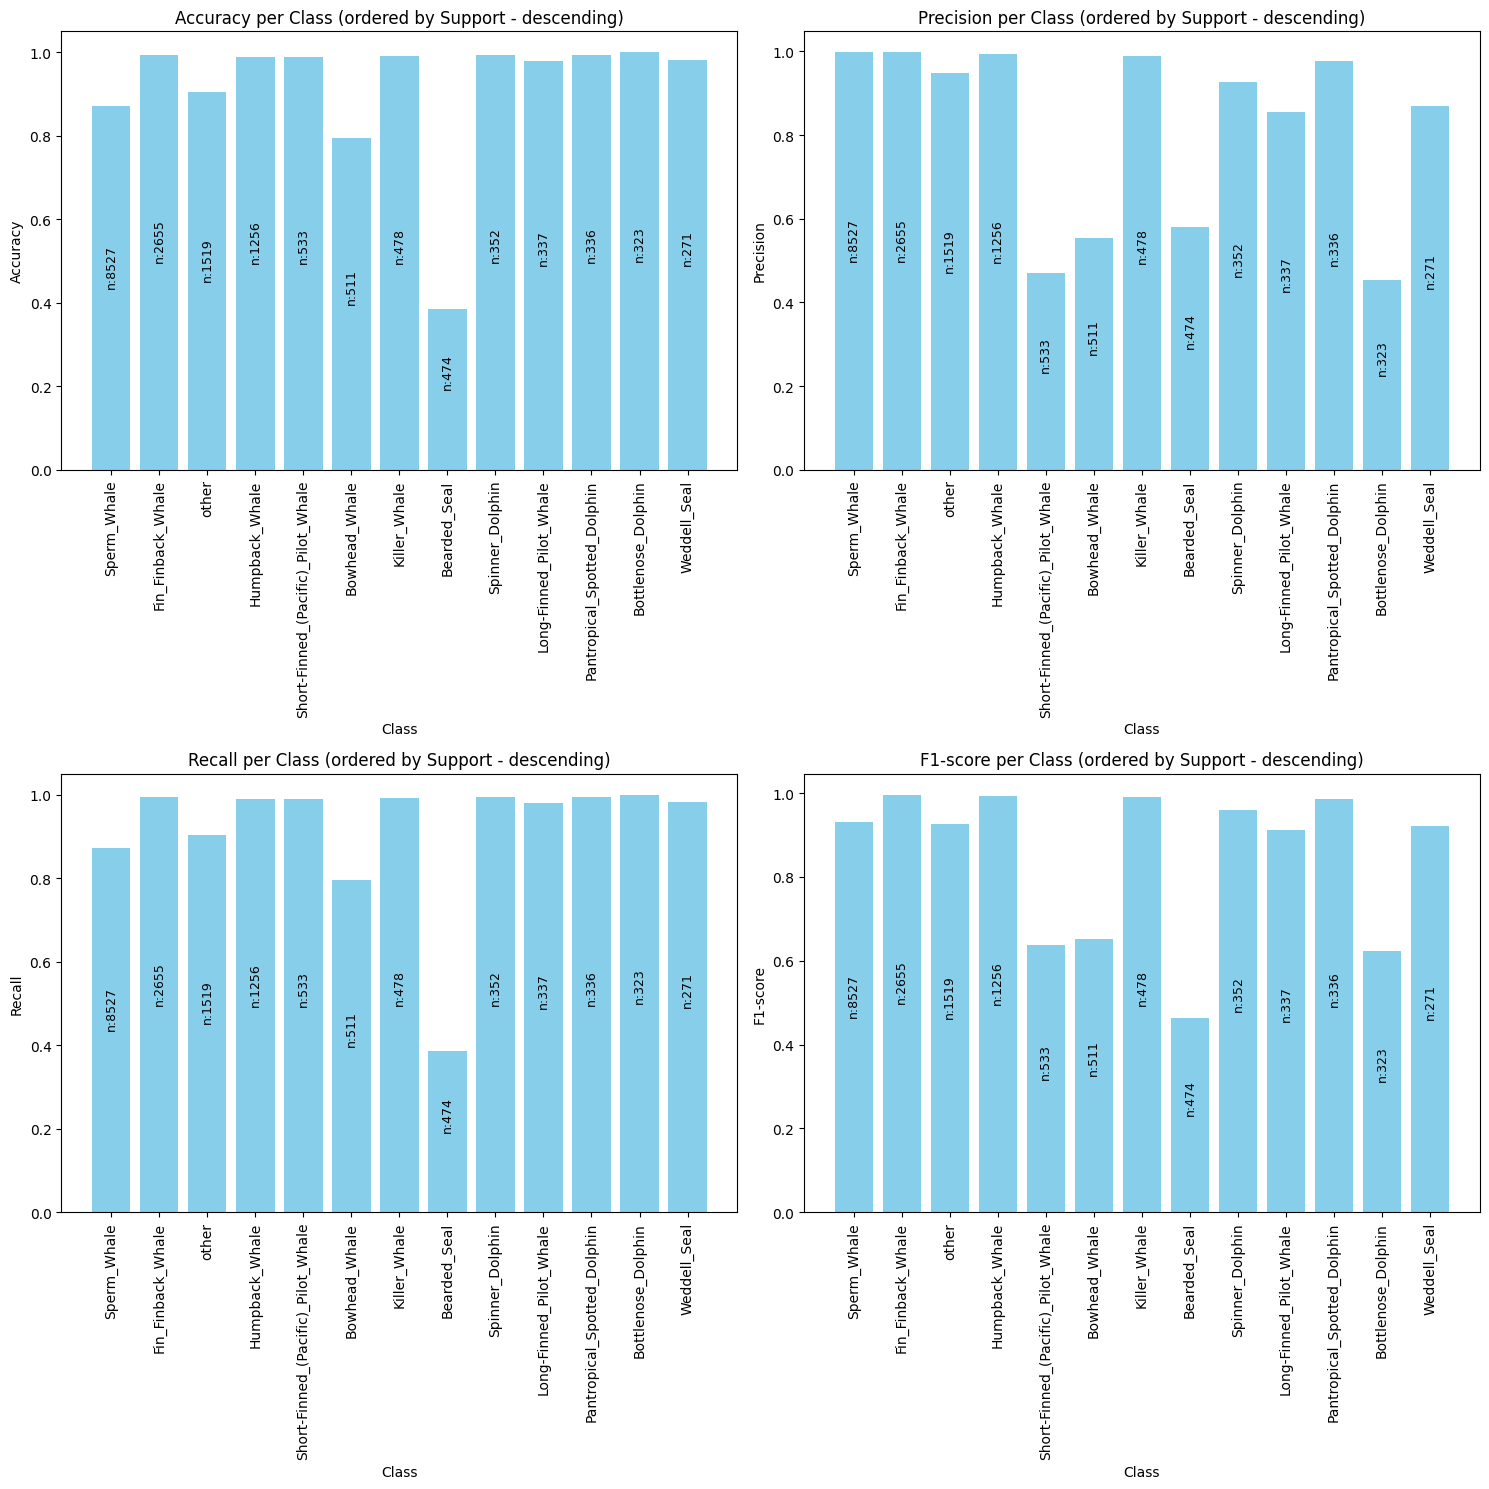

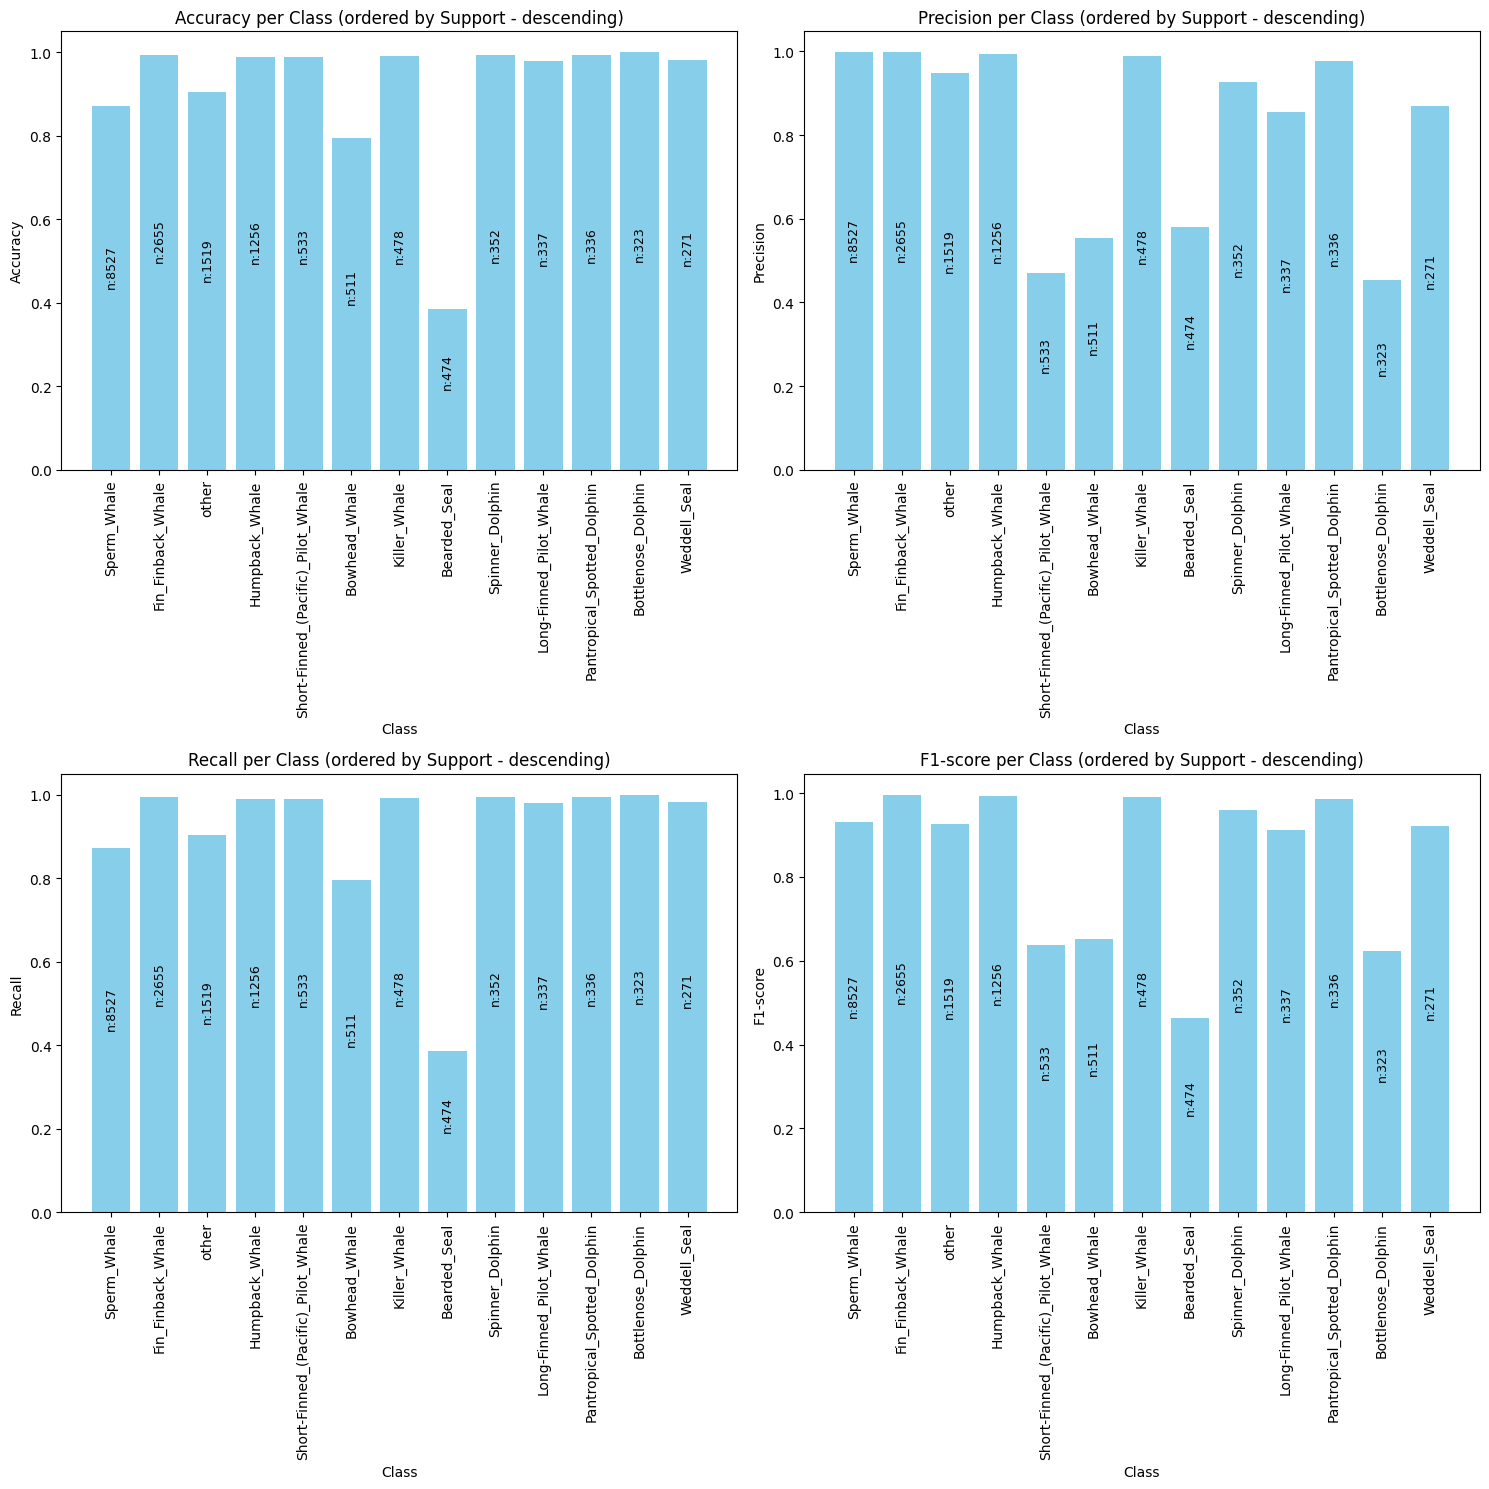

In [30]:
cnn_pred_df = pd.read_csv("cnn_predictions.csv")
num_classes = cnn_pred_df['index_label'].nunique()

y_pred = cnn_pred_df['CNN_predicted_index'].values
y_true = cnn_pred_df['index_label'].values
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes)
cm = cm.numpy()

cm_label = pd.read_csv(os.path.join("models_metrics", '14-10_training', "label_to_index.csv"))
cm_label = cm_label.sort_values('index')
cm_label_list = cm_label['label'].values.tolist()[:num_classes]

confusion_matrix_plot(cm, cm_label_list)
support = cm.sum(axis=1)
cm_label['support'] = support

label_dict = cm_label.to_dict('index')
print(label_dict)
metrics_df = get_metrics(cm, label_dict)
metrics_plot_builder(metrics_df)

## Grafici Random Forest

In [ ]:
y_pred = random_forest_model.predict(x_test)

print("--- Risultati di Classificazione ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Report:")
print(classification_report(y_test, y_pred))


--- Risultati di Classificazione ---
Accuratezza generale: 0.9592

Report Dettagliato:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       234
           1       0.99      1.00      1.00       170
           2       1.00      0.98      0.99        93
           3       0.96      0.99      0.97       116
           4       0.97      0.98      0.97        86
           5       1.00      0.99      0.99        79
           6       0.97      0.96      0.97        72
           7       0.98      1.00      0.99        65
           8       0.68      0.67      0.67        48
           9       1.00      0.96      0.98        52
          10       1.00      0.94      0.97        32
          11       1.00      1.00      1.00        35
          12       1.00      1.00      1.00        31
          13       1.00      1.00      1.00        33
          14       1.00      1.00      1.00        33
          15       1.00      1.00      1.00    

/home/elisa/miniconda3/envs/.mmd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/elisa/miniconda3/envs/.mmd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/elisa/miniconda3/envs/.mmd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

/home/elisa/FewShotLearning/ds_creation/plot_utility.py:170: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]
/home/elisa/miniconda3/envs/.mmd_env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2625: RuntimeWarning: invalid value encountered in custom_format (vectorized)
  outputs = ufunc(*args, out=...)


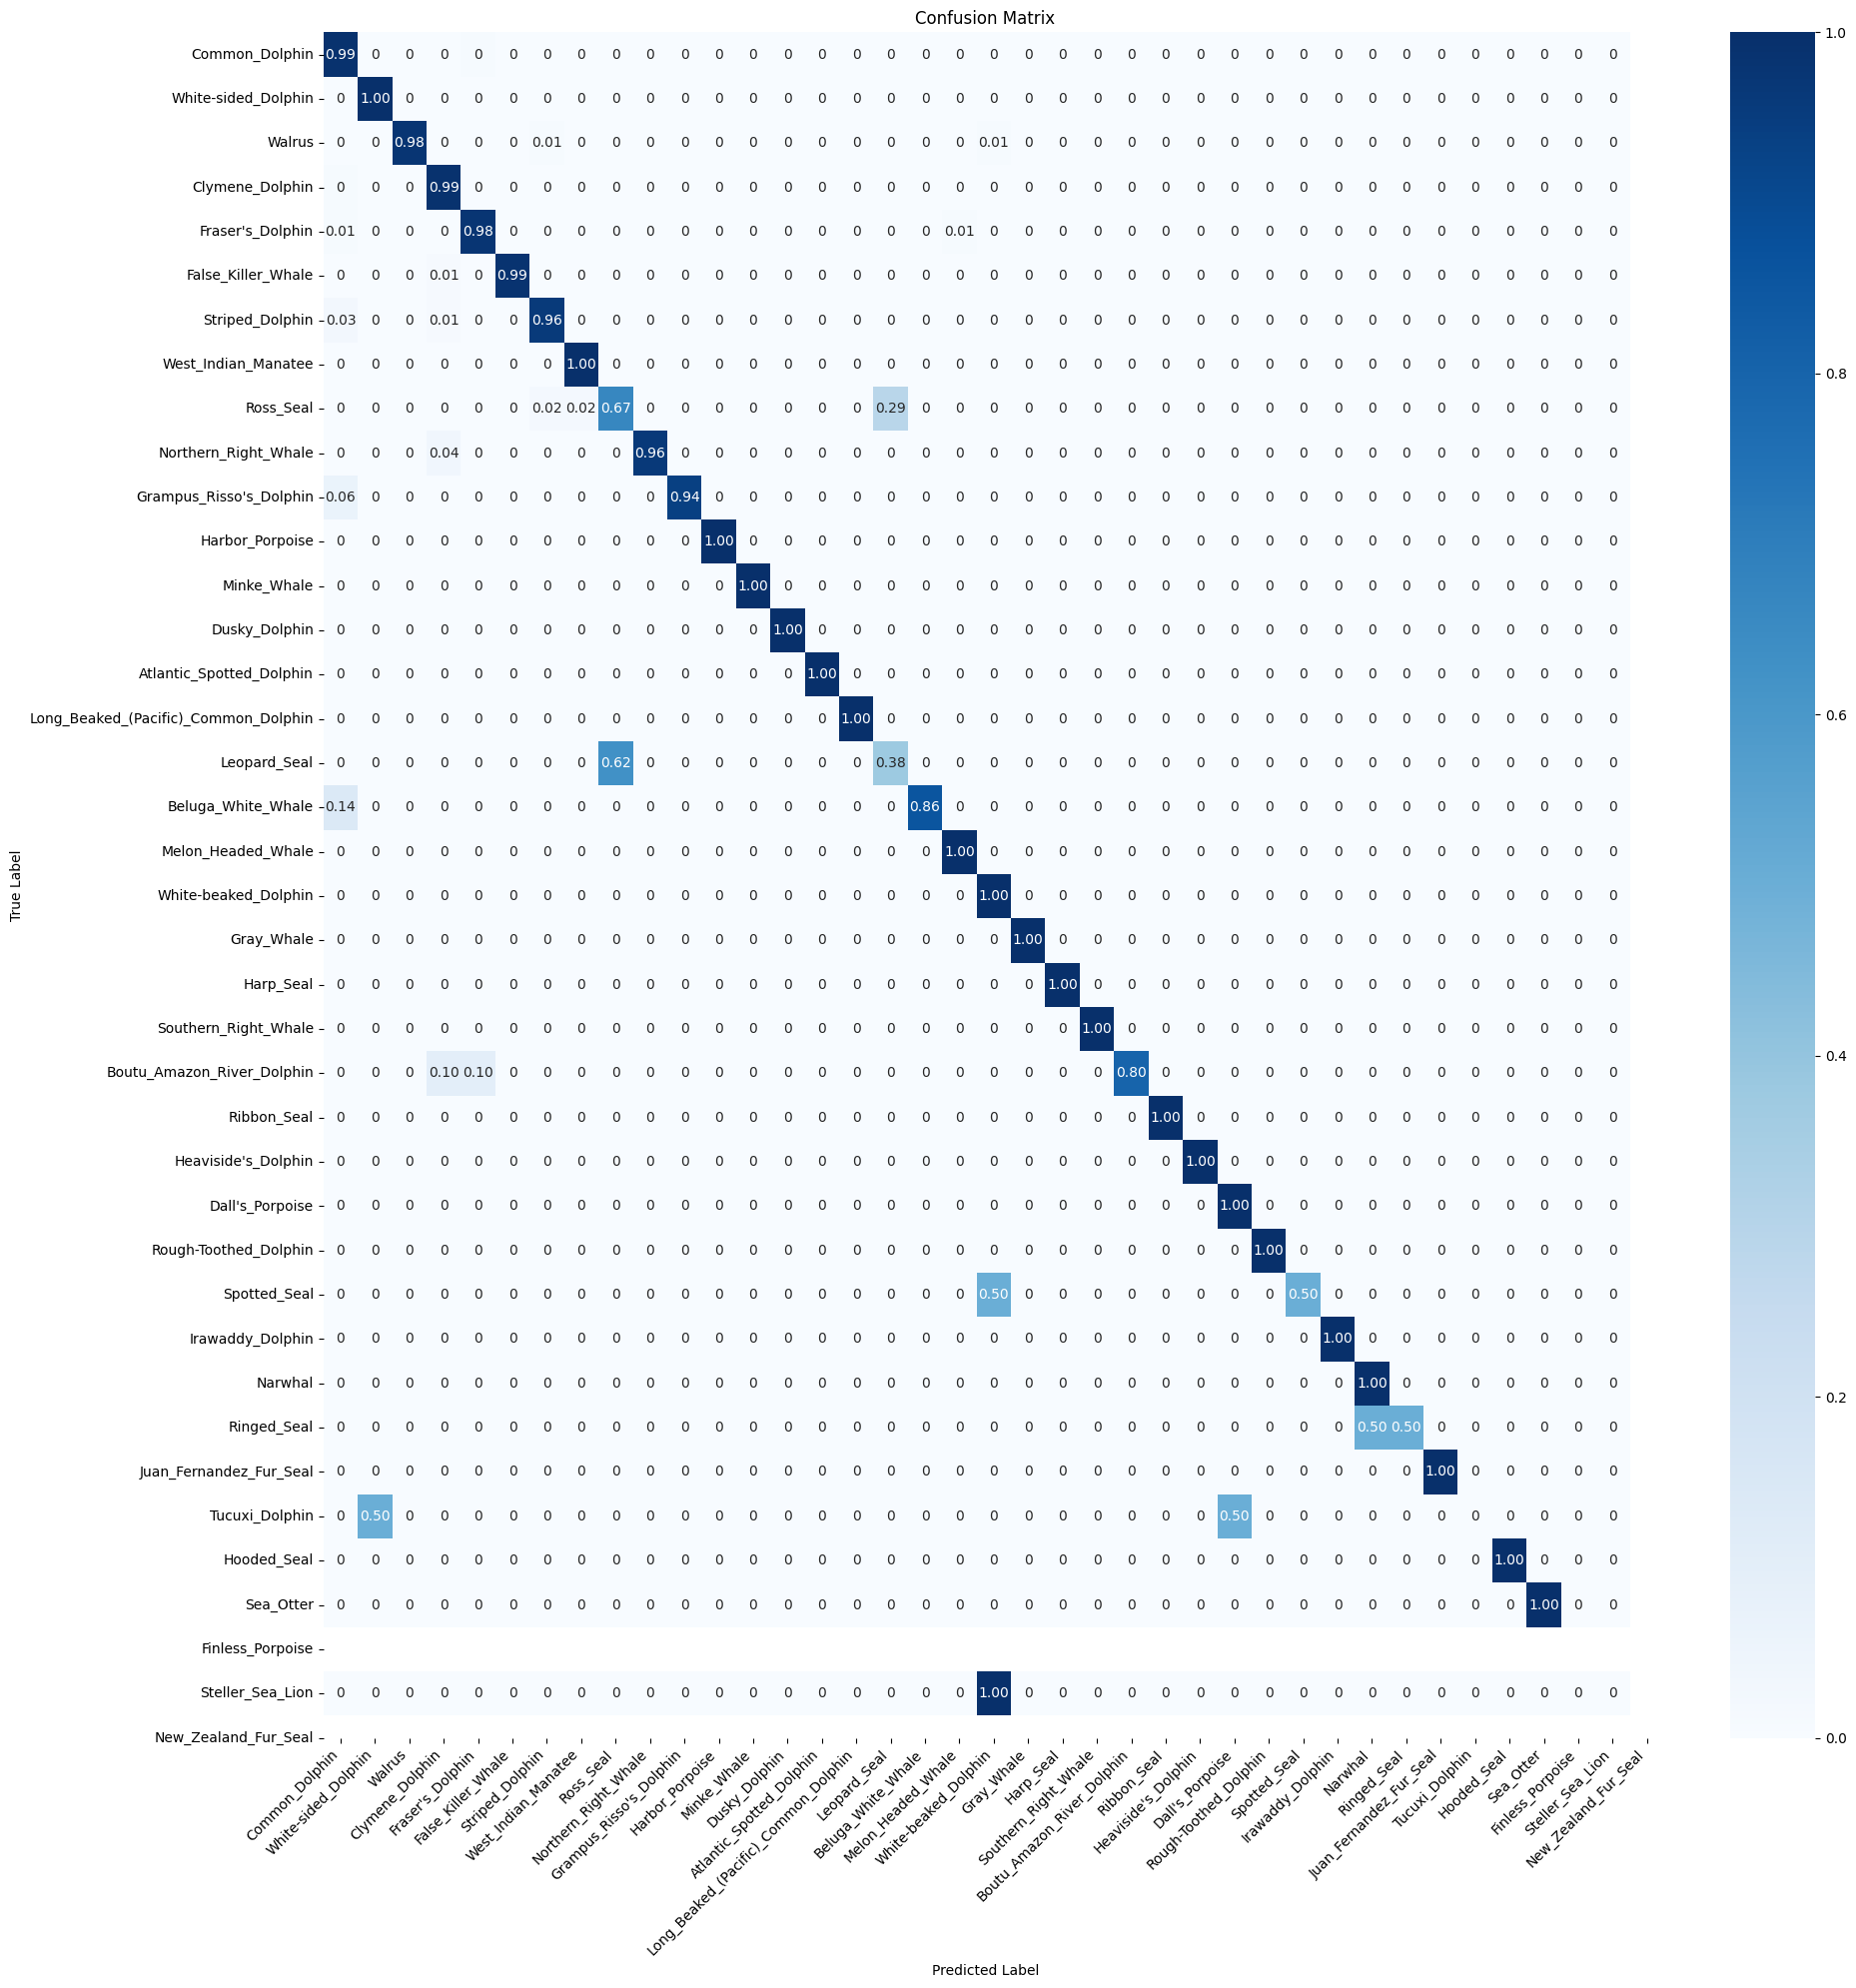

In [32]:
label_list = list(label_to_index_mapping_forest['label'].to_list())
cm = tf.math.confusion_matrix(y_test, y_pred).numpy()
accuracy_dict = confusion_matrix_plot(cm, label_list)

## Grafici Proto

In [33]:
proto_pred = pd.read_csv("proto_predictions.csv")

proto_pred['label'] = proto_pred.apply(lambda x: 'CNN_error' if x['other']==0 else x['label'], axis=1)
cnn_error_count = len(proto_pred[proto_pred['label']=='CNN_error'])
label_list = proto_pred['label'].unique().tolist()+proto_pred['proto_predicted_label'].unique().tolist()
label_list = list(set(label_list))

/home/elisa/FewShotLearning/ds_creation/plot_utility.py:170: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]
/home/elisa/miniconda3/envs/.mmd_env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2625: RuntimeWarning: invalid value encountered in custom_format (vectorized)
  outputs = ufunc(*args, out=...)


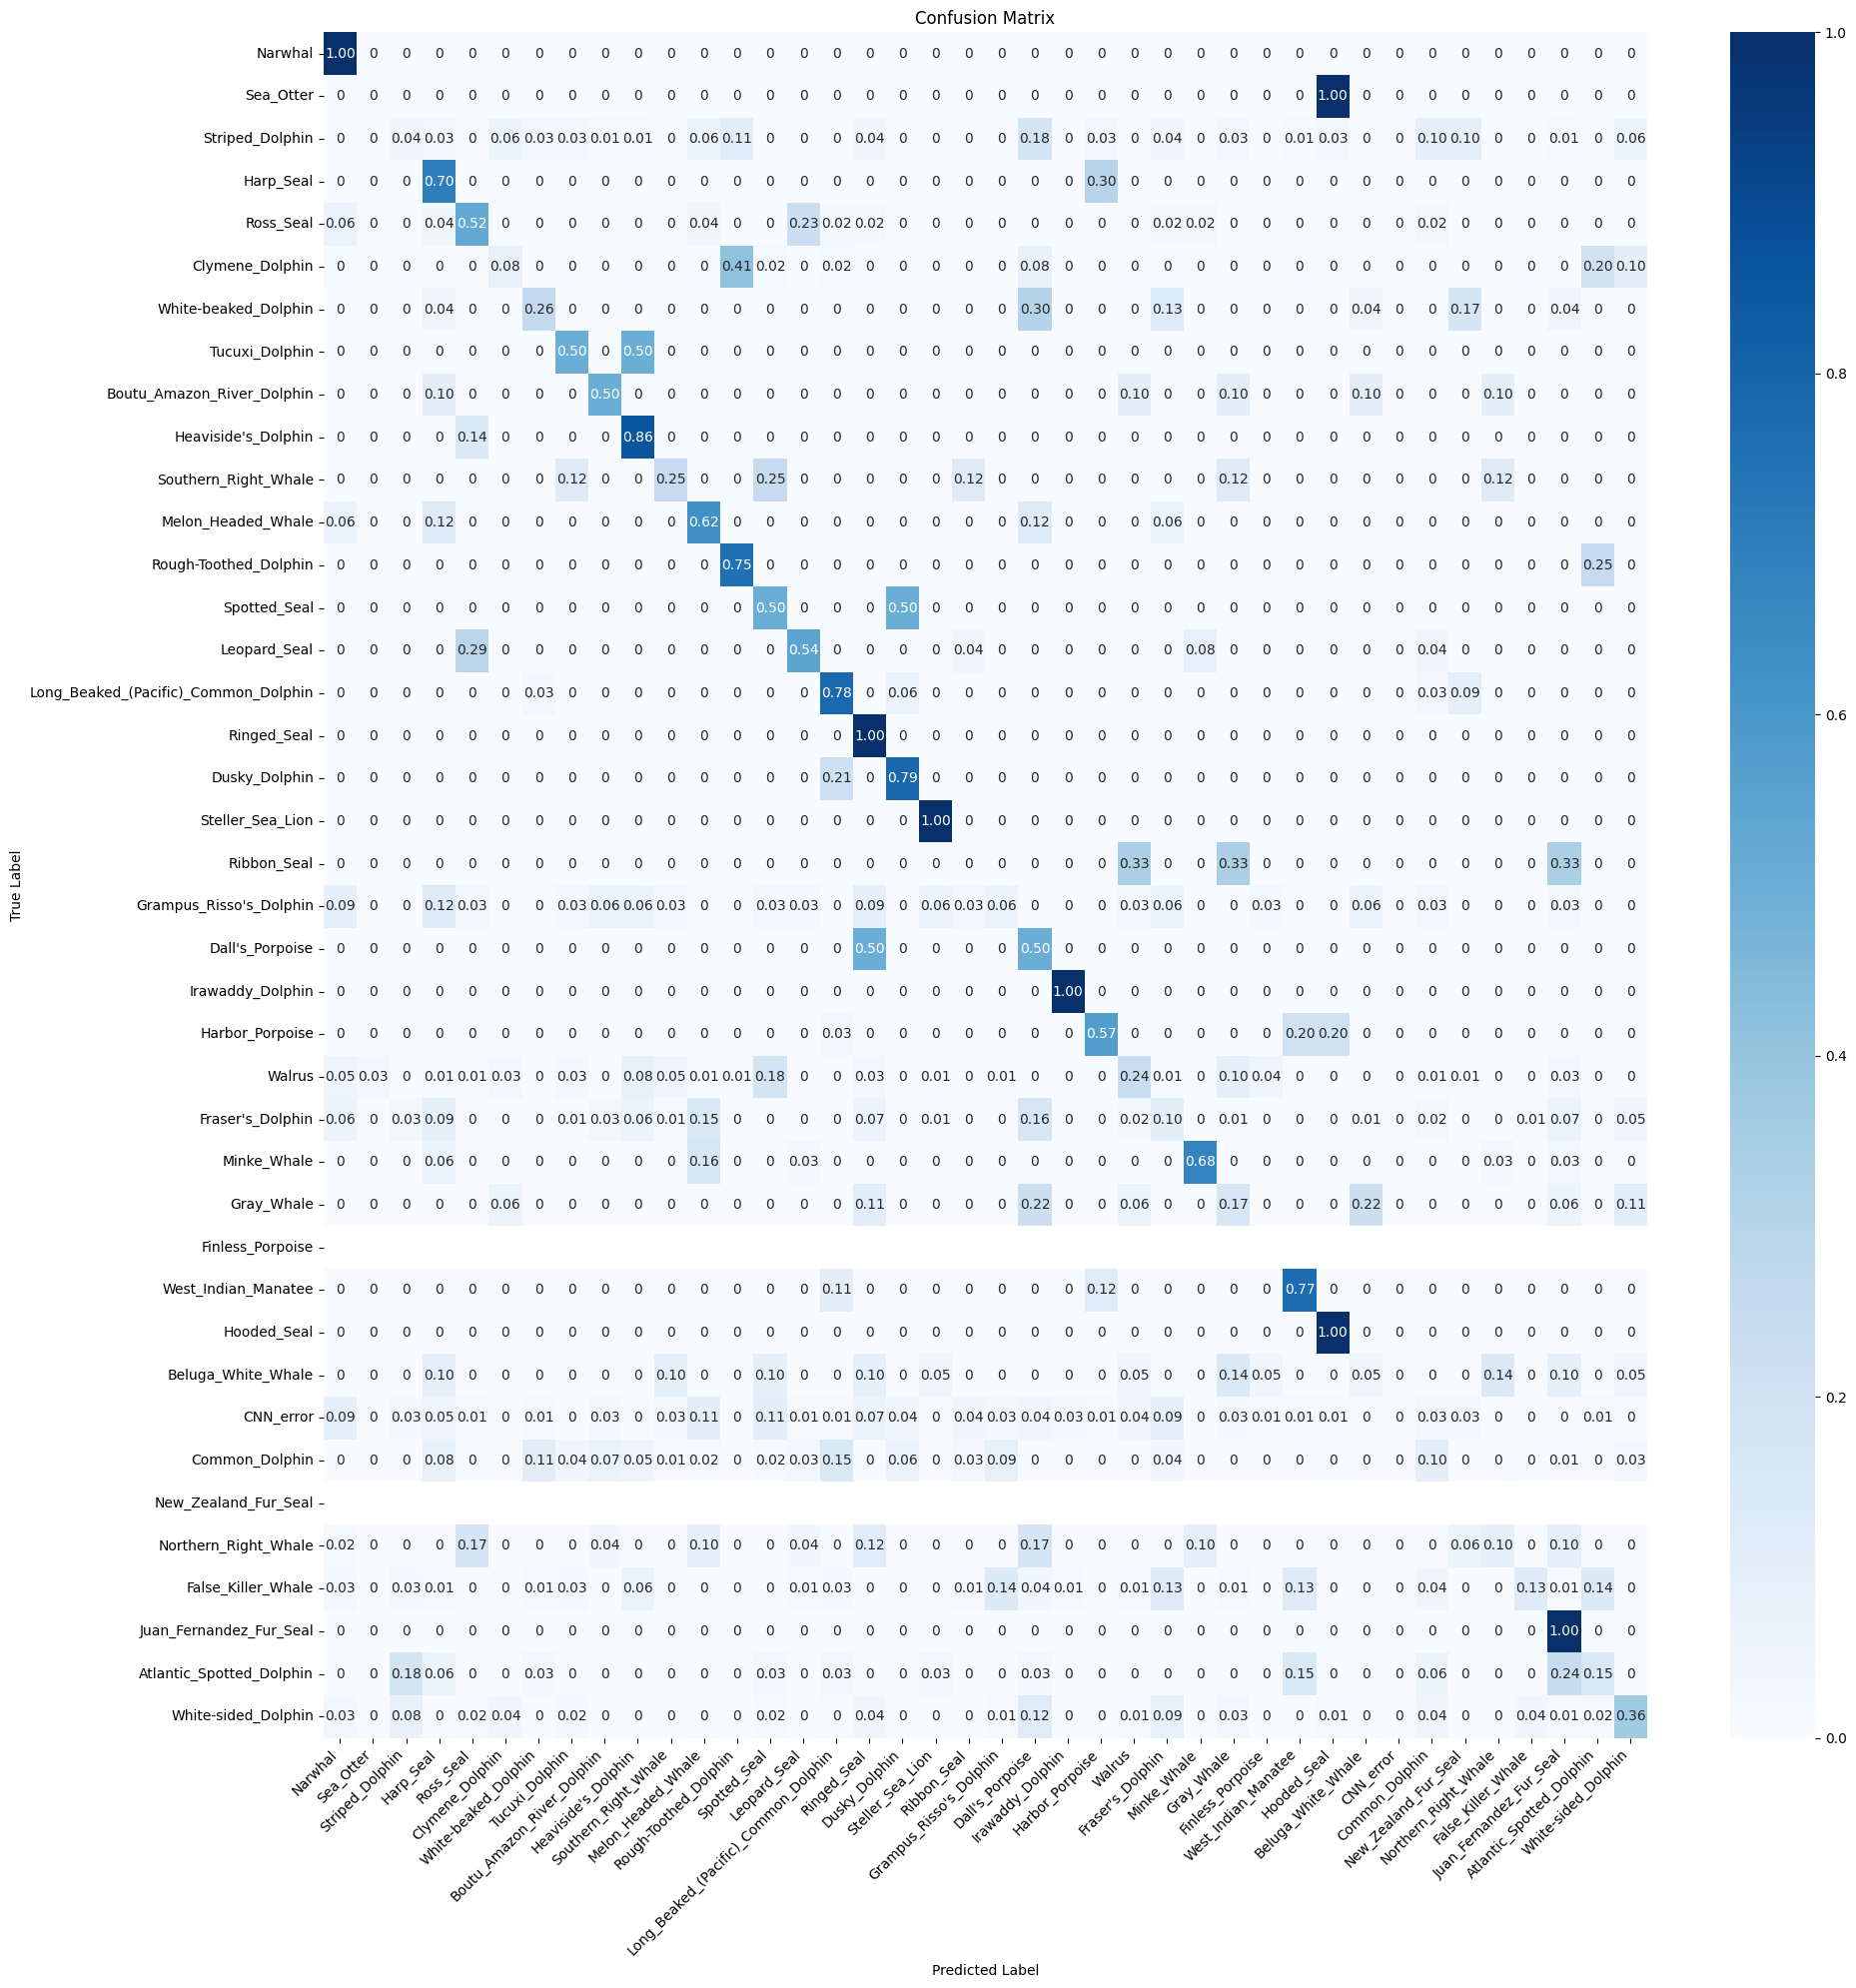

                                   class  correct_predictions   accuracy  \
32                             CNN_error                    0  76.000000   
0                                Narwhal                    3   1.000000   
18                      Steller_Sea_Lion                    1   1.000000   
30                           Hooded_Seal                    2   1.000000   
9                    Heaviside's_Dolphin                    6   0.857143   
17                         Dusky_Dolphin                   26   0.787879   
15  Long_Beaked_(Pacific)_Common_Dolphin                   25   0.781250   
29                   West_Indian_Manatee                   50   0.769231   
12                 Rough-Toothed_Dolphin                    3   0.750000   
16                           Ringed_Seal                    2   0.666667   
26                           Minke_Whale                   21   0.617647   
23                       Harbor_Porpoise                   20   0.571429   
21          

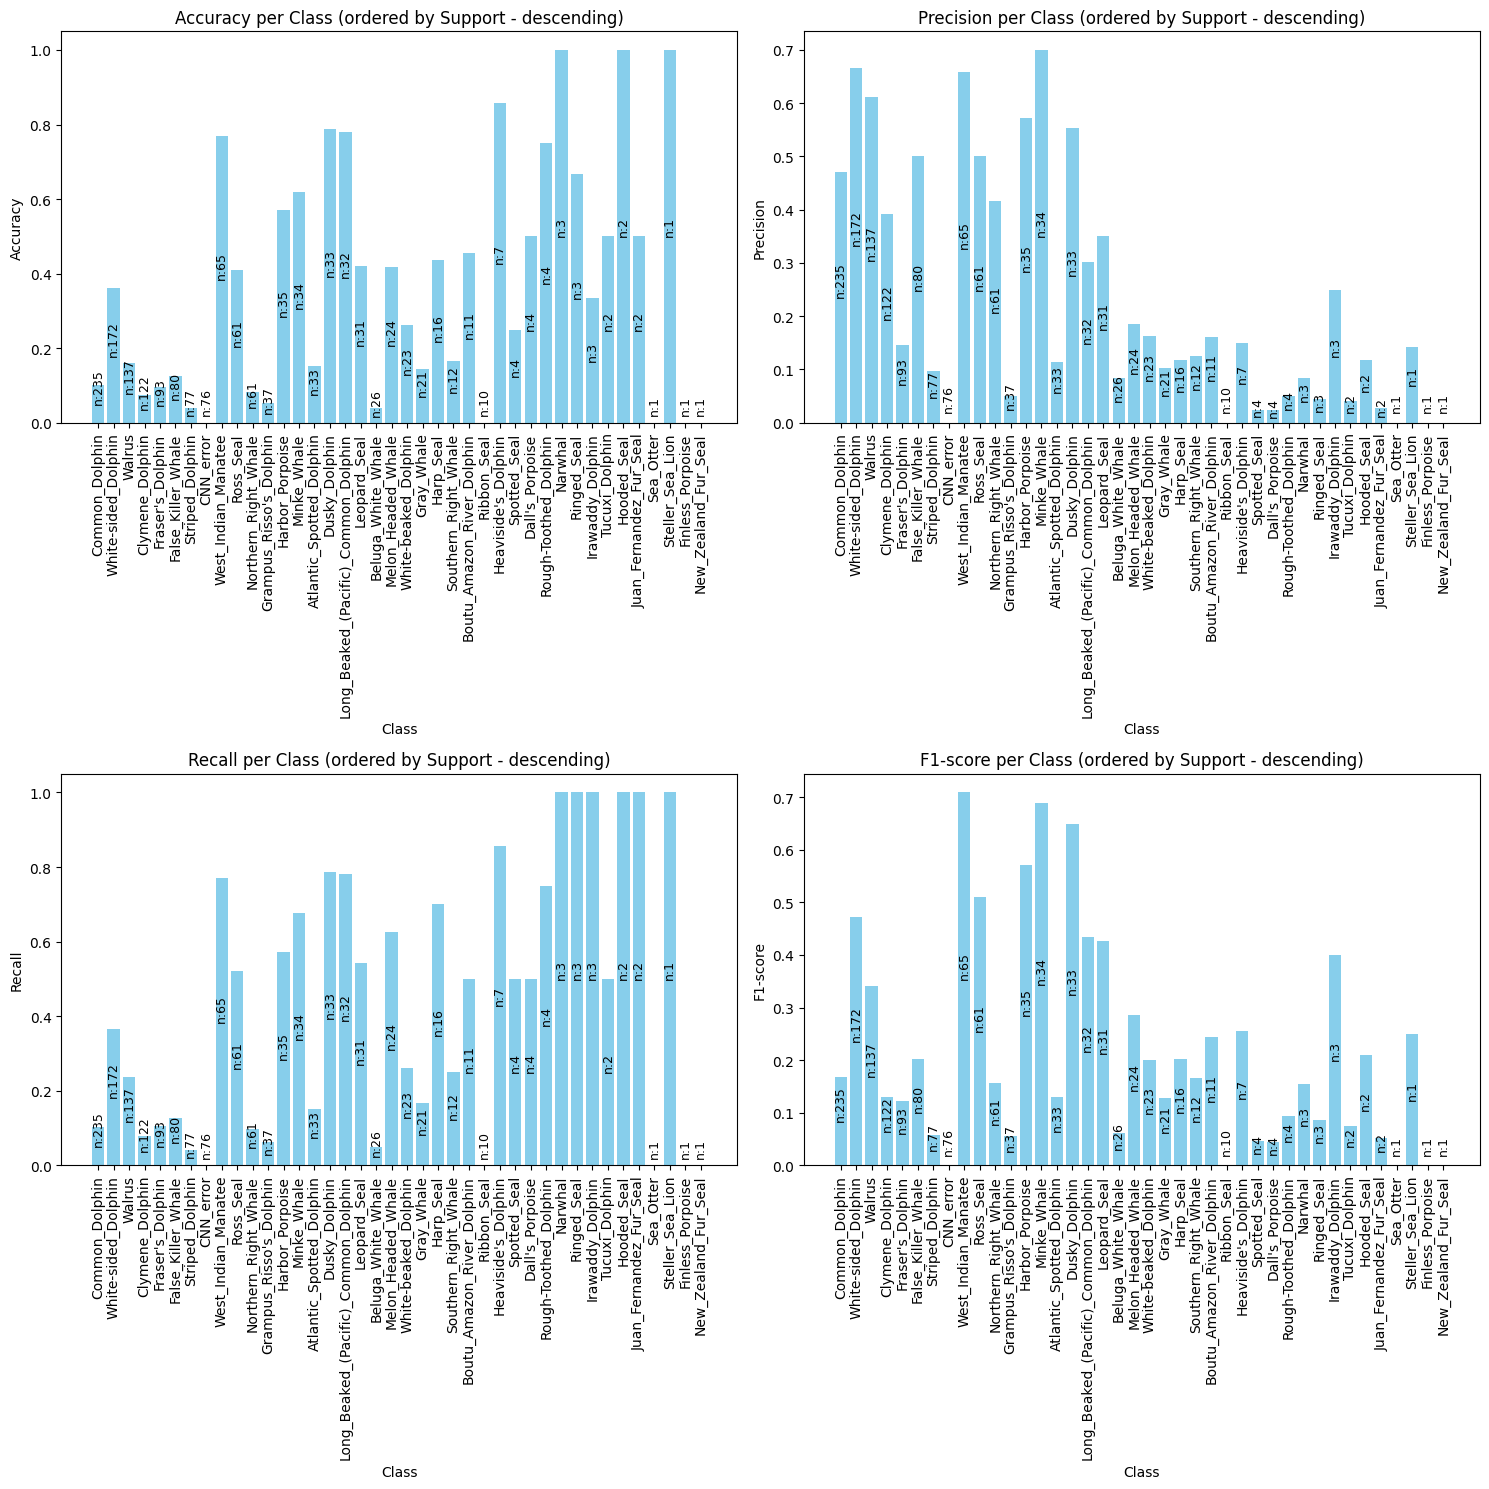

In [34]:
proto_mapping = {label:i for i, label in enumerate(label_list)}

proto_pred['index_label'] = proto_pred.apply(lambda x: proto_mapping[x['label']], axis=1)
proto_pred['proto_predicted_index'] = proto_pred.apply(lambda x: proto_mapping[x['proto_predicted_label']], axis=1)

y_pred = proto_pred['proto_predicted_index'].values
y_true = proto_pred['index_label'].values

cm = tf.math.confusion_matrix(y_true, y_pred,).numpy()
accuracy_dict = confusion_matrix_plot(cm, label_list)

accuracy_df = pd.DataFrame(list(accuracy_dict.items()), columns=['class', 'correct_predictions'])
accuracy_df['accuracy'] = accuracy_df.apply(lambda x: x['correct_predictions']/len(os.listdir(os.path.join(DATA_DIR, x['class']))) if x['class']!='CNN_error' else cnn_error_count, axis=1)
accuracy_df['sample'] = accuracy_df['class'].apply(lambda x: len(os.listdir(os.path.join(DATA_DIR, x))) if x != 'CNN_error' else 0)
accuracy_df = accuracy_df.sort_values('accuracy', ascending=False)


proto_inverse_mapping = {y:{'label':x, 'support': len(os.listdir(os.path.join(DATA_DIR, x)))} for x, y in proto_mapping.items() if x != 'CNN_error' and y!=proto_mapping['CNN_error']} 
proto_inverse_mapping[proto_mapping['CNN_error']] = {'label':'CNN_error', 'support':cnn_error_count}

metrics_df = get_metrics(cm, proto_inverse_mapping)
metrics_plot_builder(metrics_df)
print(accuracy_df)

